In [1]:
import os

import pandas as pd
from IPython.display import display

pd.options.display.float_format = '{:.2f}'.format
import warnings
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import *
from statsmodels.stats.multicomp import pairwise_tukeyhsd

warnings.filterwarnings("ignore")

In [2]:
file_paths = [f"GT_error/hirasaki_{i}_errors.csv" for i in range(10)]
dataframes = [pd.read_csv(file_path) for file_path in file_paths]

In [3]:
frame_wise_avg_mpjpe_combinations_revised = {n: [] for n in range(2, 6)}

for n in range(5):
    for combo_indices in combinations(range(5), n + 2):
        for df in dataframes:
            combo_col_name = f"{''.join(map(str, combo_indices))}_mpjpe"
            if combo_col_name in df.columns:
                frame_wise_avg_mpjpe_combinations_revised[n + 2].extend(df[combo_col_name].values)

print("Number of combinations for each n:")
for n, values in frame_wise_avg_mpjpe_combinations_revised.items():
    print(f"n={n}: {len(values)}")

Number of combinations for each n:
n=2: 18440
n=3: 18440
n=4: 9220
n=5: 1844


In [4]:
raw_combination_data = []
for df in dataframes:
    for col in df.columns:
        if "_mpjpe" in col or "_angle" in col:
            error_type = "MPJPE" if "_mpjpe" in col else col.split('_')[1] + " " + col.split('_')[2]
            if len(col.split('_')) == 6:
                error_type += " " + col.split('_')[3]
            for value in df[col].values:
                raw_combination_data.append({"Combination": col.split('_')[0], "Error Type": error_type, "Error Value": value})

raw_combination_df = pd.DataFrame(raw_combination_data)
raw_combination_df.head()

,Combination,Error Type,Error Value
0,01,MPJPE,15.95
1,01,MPJPE,15.69
2,01,MPJPE,15.46
3,01,MPJPE,15.26
4,01,MPJPE,15.04


In [5]:
mpjpe_df = raw_combination_df[(raw_combination_df["Error Type"] == "MPJPE") & (raw_combination_df["Combination"] != "04")]
display(mpjpe_df)

,Combination,Error Type,Error Value
0,01,MPJPE,15.95
1,01,MPJPE,15.69
2,01,MPJPE,15.46
3,01,MPJPE,15.26
4,01,MPJPE,15.04
...,...,...,...
334439,01234,MPJPE,7.92
334440,01234,MPJPE,8.00
334441,01234,MPJPE,8.14
334442,01234,MPJPE,8.32


In [6]:
mean_values = [mpjpe_df[mpjpe_df["Combination"].str.len() == n]["Error Value"].mean() for n in range(2, 6)]
std_values = [mpjpe_df[mpjpe_df["Combination"].str.len() == n]["Error Value"].std() for n in range(2, 6)]

print("Mean values for each n:")
for n, mean, std in zip(range(2, 6), mean_values, std_values):
    print(f"n={n}: {mean:.2f} ± {std:.2f}")

reduction_rates = [(mean_values[n] - mean_values[n + 1]) / mean_values[n] * 100 for n in range(3)]
print(f"Decreasing rates for each n:")
for n, rate in enumerate(reduction_rates):
    print(f"{n + 2} -> {n + 3}: {rate:.2f}")

diminishing_rates = [reduction_rates[n] - reduction_rates[n + 1] for n in range(2)]
print(f"Diminishing rates for each n:")
for n, rate in enumerate(diminishing_rates):
    print(f"{n + 2} -> {n + 3} -> {n + 4}: {rate:.2f}")

Mean values for each n:
n=2: 16.19 ± 9.94
n=3: 11.11 ± 5.35
n=4: 8.59 ± 3.51
n=5: 6.79 ± 1.75
Decreasing rates for each n:
2 -> 3: 31.37
3 -> 4: 22.75
4 -> 5: 20.90
Diminishing rates for each n:
2 -> 3 -> 4: 8.62
3 -> 4 -> 5: 1.85


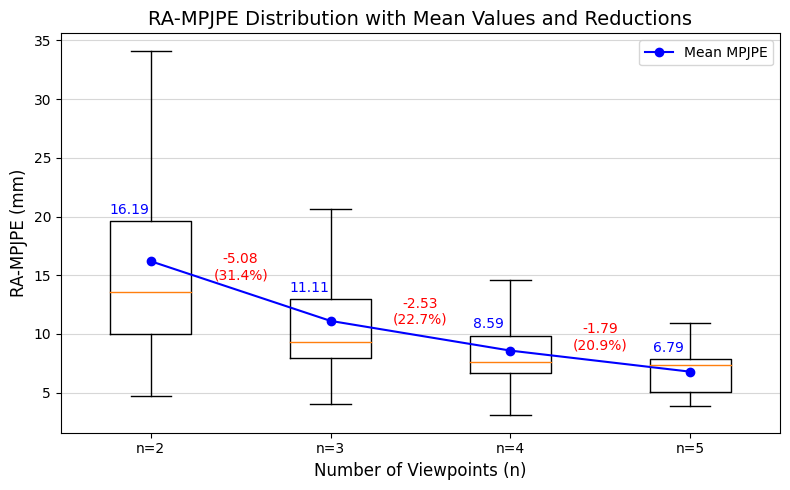

In [7]:
plt.figure(figsize=(8, 5))
boxplot_data = []
q3_values = []

for n in range(2, 6):
    values = mpjpe_df[mpjpe_df["Combination"].str.len() == n]["Error Value"]
    boxplot_data.append(values)
    q3_values.append(values.quantile(0.75))

plt.boxplot(boxplot_data, labels=[f"n={n}" for n in range(2, 6)], showfliers=False)

plt.plot(range(1, 5), mean_values, marker='o', linestyle='-', color='blue', label="Mean MPJPE")

for i, (start, end) in enumerate(zip(mean_values[:-1], mean_values[1:])):
    diff = start - end
    rate = diff / start * 100
    plt.text(i + 1.5, (start + end) / 2 + 1, f"-{diff:.2f}\n({rate:.1f}%)", ha='center', fontsize=10, color='red')

for i, (mean, q3) in enumerate(zip(mean_values, q3_values)):
    plt.text(i + 0.88, q3 + 0.6, f"{mean:.2f}", ha='center', fontsize=10, color='blue')

plt.title("RA-MPJPE Distribution with Mean Values and Reductions", fontsize=14)
plt.xlabel("Number of Viewpoints (n)", fontsize=12)
plt.ylabel("RA-MPJPE (mm)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
values_2 = mpjpe_df[mpjpe_df["Combination"].str.len() == 2]["Error Value"]
values_3 = mpjpe_df[mpjpe_df["Combination"].str.len() == 3]["Error Value"]
values_4 = mpjpe_df[mpjpe_df["Combination"].str.len() == 4]["Error Value"]
values_5 = mpjpe_df[mpjpe_df["Combination"].str.len() == 5]["Error Value"]

stat_levene, p_levene = levene(values_2, values_3, values_4, values_5)
print(f"Levene's test: stat={stat_levene:.4f}, p={p_levene:.4f}")

stat_fligner, p_fligner = fligner(values_2, values_3, values_4, values_5)
print(f"Fligner-Killeen test: stat={stat_fligner:.4f}, p={p_fligner:.4f}")

stat_kruskal, p_kruskal = kruskal(values_2, values_3, values_4, values_5)

def cliffs_delta(a, b):
    m, n = len(a), len(b)
    rank = np.argsort(np.concatenate([a, b]))
    a_ranks = np.sum(rank[:m])
    b_ranks = np.sum(rank[m:])
    return (2 * a_ranks / m - (m + 1)) / n - 0.5

cliffs_effects = {
    f"{n1} vs {n2}": cliffs_delta(
        mpjpe_df[mpjpe_df["Combination"].str.len() == n1]["Error Value"],
        mpjpe_df[mpjpe_df["Combination"].str.len() == n2]["Error Value"],
    )
    for n1, n2 in [(2, 3), (3, 4), (4, 5)]
}

print(f"Kruskal-Wallis test: stat={stat_kruskal:.4f}, p={p_kruskal:.4f}")
print("\nCliff's Delta Effect Sizes (pairwise comparisons):")
for pair, delta in cliffs_effects.items():
    print(f"{pair}: {delta:.4f}")

Levene's test: stat=1712.3576, p=0.0000
Fligner-Killeen test: stat=7268.8400, p=0.0000
Kruskal-Wallis test: stat=10132.0564, p=0.0000

Cliff's Delta Effect Sizes (pairwise comparisons):
2 vs 3: 0.8465
3 vs 4: 0.6701
4 vs 5: 0.7043
